In [1]:
import pandas as pd
import numpy as np
import random
import copy
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import patches
import brewer2mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pylab

import folium # for map visualization, and this is a new package needed to be installed from the anaconda.
from folium import plugins
from folium.plugins import HeatMap

from sklearn import datasets, linear_model, neighbors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors.kde import KernelDensity
from sklearn.svm import SVR 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

import statsmodels.api as sm
import statsmodels.formula.api as smf

import os

import itertools

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
""" Some tutorials:
Data:
https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

Map Folium:
http://www.kobakhit.com/beginner/2016/03/06/visualizing-indego-bike-geoson-data-in-python-using-folium.html
http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/

Outliers: 
http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm

"""

In [2]:
"""Read in original data and deal with "date":

"""

# Read in data, and cleaned the 'date' as a date type.
df=pd.read_csv('kc_house_data.csv', parse_dates = ['date'])

# Taking out un-needed variables
df = df.drop(df.columns[[0, 11, 15, 16, 19, 20]], axis=1)

# Add year and month: 
df['yr'] = df['date'].dt.year
df['month'] = df['date'].dt.month

#Index months: from 1 to 13, for May 2014 to May 2015 respectively.

# If year is 2015, then new month equals to old month plus 12, then replace NaNs with old months:
df["month_temp"] = df["month"][df["yr"] == 2015] + 12
df["month_temp"].fillna(df["month"], inplace = True)

# Adjust the indexes for months, rescale from 1 to 13:
df["month_all"] = df["month_temp"] - 4

# Only keep the month_all column:
df.drop(['month_temp'], axis=1, inplace = True)

df.head(7)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,lat,long,yr,month,month_all
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,1180,0,1955,47.5112,-122.257,2014,10,6.0
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,2170,400,1951,47.7210,-122.319,2014,12,8.0
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,770,0,1933,47.7379,-122.233,2015,2,10.0
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,1050,910,1965,47.5208,-122.393,2014,12,8.0
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,1680,0,1987,47.6168,-122.045,2015,2,10.0
5,2014-05-12,1225000.0,4,4.50,5420,101930,1.0,0,0,3,3890,1530,2001,47.6561,-122.005,2014,5,1.0
6,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,3,1715,0,1995,47.3097,-122.327,2014,6,2.0


In [3]:
""" Index months: from 1 to 13, for May 2014 to May 2015 respectively.

"""

# If year is 2015, then new month equals to old month plus 12, then replace NaNs with old months:
df["month_temp"] = df["month"][df["yr"] == 2015] + 12
df["month_temp"].fillna(df["month"], inplace = True)

# Adjust the indexes for months, rescale from 1 to 13:
df["month_all"] = df["month_temp"] - 4

# Only keep the month_all column:
df.drop(['month_temp'], axis=1, inplace = True)

# Create Grade = waterfront + view + condition
df["Grade"] = df["waterfront"] + df["view"] + df["condition"]

df.head(7)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,lat,long,yr,month,month_all,Grade
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,1180,0,1955,47.5112,-122.257,2014,10,6.0,3
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,2170,400,1951,47.7210,-122.319,2014,12,8.0,3
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,770,0,1933,47.7379,-122.233,2015,2,10.0,3
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,1050,910,1965,47.5208,-122.393,2014,12,8.0,5
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,1680,0,1987,47.6168,-122.045,2015,2,10.0,3
5,2014-05-12,1225000.0,4,4.50,5420,101930,1.0,0,0,3,3890,1530,2001,47.6561,-122.005,2014,5,1.0,3
6,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,3,1715,0,1995,47.3097,-122.327,2014,6,2.0,3


In [4]:
"""Make Logged columns and creat new columns:

"""
df["logged_price"] =  np.log(df["price"])
df["logged_living"] = np.log(df["sqft_living"])
df["logged_lot"] = np.log(df["sqft_lot"])
df["logged_above"] = np.log(df["sqft_above"])


print(df.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'yr', 'month', 'month_all',
       'Grade', 'logged_price', 'logged_living', 'logged_lot', 'logged_above'],
      dtype='object')


In [5]:
df.drop(['waterfront'], axis=1, inplace = True)
df.drop(['view'], axis=1, inplace = True)
df.drop(['condition'], axis=1, inplace = True)
df.drop(['month'], axis=1, inplace = True)

print(df.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long',
       'yr', 'month_all', 'Grade', 'logged_price', 'logged_living',
       'logged_lot', 'logged_above'],
      dtype='object')


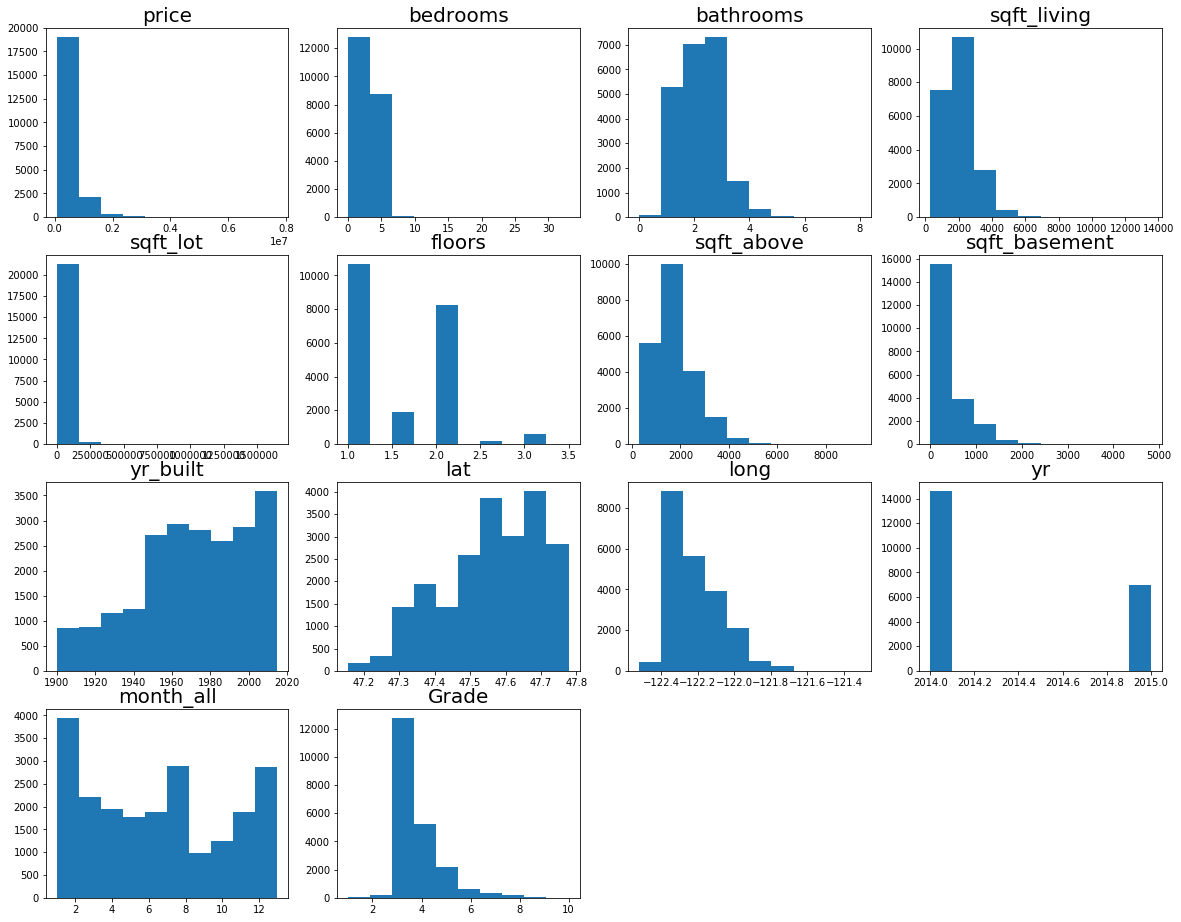

'# Step 2: run the KS-tests for each of the variables, with a normal distribution of the variable mean and variable stds.\nlst_continuous = ["price", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement"]\n\nfor ele in lst_continuous:\n    mean = np.mean(df[ele])\n    std = np.std(df[ele])\n    \n    df_normal = np.random.normal(loc=mean, scale=std, size=1000)\n    \n    results = stats.ks_2samp(df[ele], df_normal)\n    print("Results for {}: Statistic = {}, p-value = {}\n".format(ele, results.statistic, results.pvalue))\n# Noted that all the null hypothesis are rejected. I need to transform. \n\n# Step 3: log all the elements in lst_continuous, and run the KS-tests as the same as the above, and graph the logged histograms.\n# Spectial note: from the previous cell, I know that "sqt_basement" has value 0, which will cause problems with log, so I exclude it here.\nlst_log = ["price", "sqft_living", "sqft_lot", "sqft_above"]\n\nfig = plt.figure(figsize=(20, 16))\nfor n, ele in zip(rang

In [20]:
"""Descriptive Figures - 1:

"""
# Step 1: Plot histograms for all the variables
fig = plt.figure(figsize=(20, 16))
for ele in range(1,15):
    ax = fig.add_subplot(4, 4, ele)
    ax.hist(df[df.columns[ele]])
    ax.set_title(df.columns[ele], fontsize = 20)

pylab.savefig('Data Histograms', dpi = 80, figsize = (20,6))
plt.show()

# Noted that bedrooms, bathrooms, floors and yr_built cannot be treated as continous variables. 

"""# Step 2: run the KS-tests for each of the variables, with a normal distribution of the variable mean and variable stds.
lst_continuous = ["price", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement"]

for ele in lst_continuous:
    mean = np.mean(df[ele])
    std = np.std(df[ele])
    
    df_normal = np.random.normal(loc=mean, scale=std, size=1000)
    
    results = stats.ks_2samp(df[ele], df_normal)
    print("Results for {}: Statistic = {}, p-value = {}\n".format(ele, results.statistic, results.pvalue))
# Noted that all the null hypothesis are rejected. I need to transform. 

# Step 3: log all the elements in lst_continuous, and run the KS-tests as the same as the above, and graph the logged histograms.
# Spectial note: from the previous cell, I know that "sqt_basement" has value 0, which will cause problems with log, so I exclude it here.
lst_log = ["price", "sqft_living", "sqft_lot", "sqft_above"]

fig = plt.figure(figsize=(20, 16))
for n, ele in zip(range(1,5), lst_log):
    ax = fig.add_subplot(2, 2, n)
    ax.hist(np.log(df[ele]))
    ax.set_title("Logged {}".format(ele), fontsize = 20)

pylab.savefig('Logged Histograms', dpi = 80, figsize = (20,6))
plt.show()

# Noted that now, the logged histograms look great, so I need to check the normality.

# Step 4: repeat step 2 with the logged data from step 3.
for ele in lst_log:
    mean = np.mean(np.log(df[ele]))
    std = np.std(np.log(df[ele]))
    
    df_normal = np.random.normal(loc=mean, scale=std, size=1000)
    
    results = stats.ks_2samp(df[ele], df_normal)
    print("Results for Logged {}: Statistic = {}, p-value = {}\n".format(ele, results.statistic, results.pvalue))

fig = plt.figure(figsize=(20, 16))    
for n, ele in zip(range(1,5), lst_log):
    ax = fig.add_subplot(2, 2, n)
    ax.boxplot(np.log(df[ele]))
    ax.set_title("Logged {}".format(ele), fontsize = 20)

pylab.savefig('Logged Data Boxplot', dpi = 80, figsize = (20,6))
plt.show()"""

In [ ]:
""" Based on the above, I want to transform some of the variables into logged data,
since normality are usually preferred/required when performing analysis, and I want to get this done before dig into the real analysis.

"""

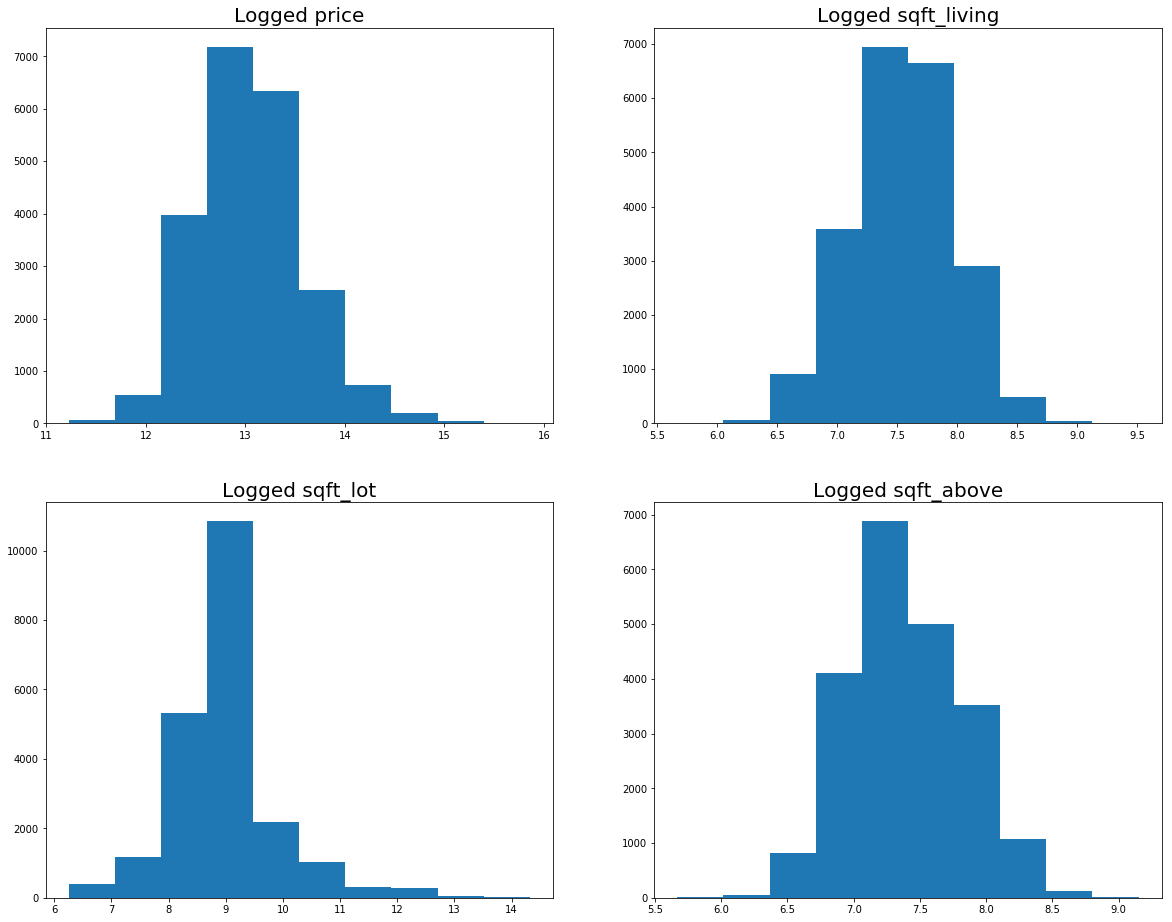

Results for Logged price: Statistic = 1.0, p-value = 0.0

Results for Logged sqft_living: Statistic = 1.0, p-value = 0.0

Results for Logged sqft_lot: Statistic = 1.0, p-value = 0.0

Results for Logged sqft_above: Statistic = 1.0, p-value = 0.0



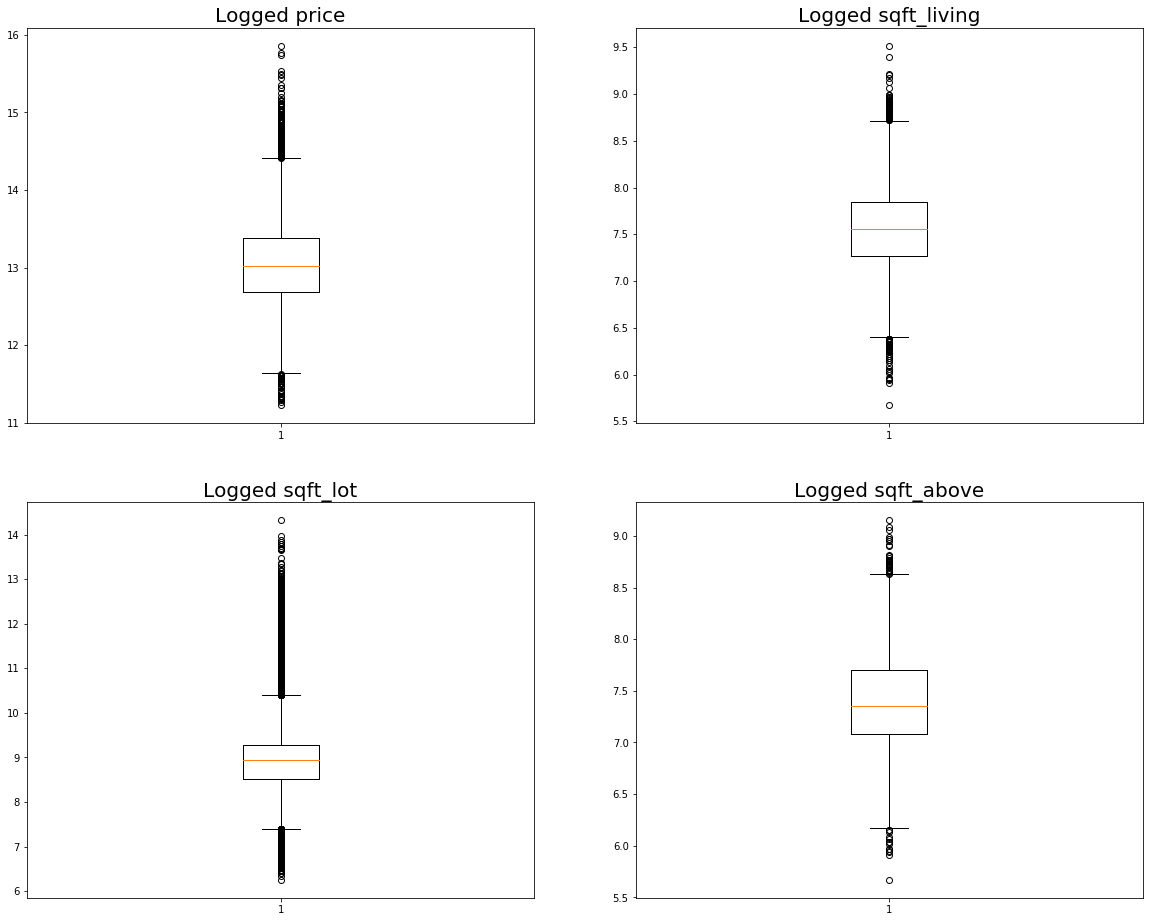

In [22]:
"""Descriptive Figures - 1: Logged data

"""

lst_log = ["price", "sqft_living", "sqft_lot", "sqft_above"]

fig = plt.figure(figsize=(20, 16))
for n, ele in zip(range(1,5), lst_log):
    ax = fig.add_subplot(2, 2, n)
    ax.hist(np.log(df[ele]))
    ax.set_title("Logged {}".format(ele), fontsize = 20)

pylab.savefig('Logged Histograms', dpi = 80, figsize = (20,6))
plt.show()

# Noted that now, the logged histograms look great, so I need to check the normality.

# Step 4: repeat step 2 with the logged data from step 3.
for ele in lst_log:
    mean = np.mean(np.log(df[ele]))
    std = np.std(np.log(df[ele]))
    
    df_normal = np.random.normal(loc=mean, scale=std, size=1000)
    
    results = stats.ks_2samp(df[ele], df_normal)
    print("Results for Logged {}: Statistic = {}, p-value = {}\n".format(ele, results.statistic, results.pvalue))

fig = plt.figure(figsize=(20, 16))    
for n, ele in zip(range(1,5), lst_log):
    ax = fig.add_subplot(2, 2, n)
    ax.boxplot(np.log(df[ele]))
    ax.set_title("Logged {}".format(ele), fontsize = 20)

pylab.savefig('Logged Data Boxplot', dpi = 80, figsize = (20,6))
plt.show()

In [7]:
"""Missing value, data types.

"""
# Check the missing value
print(df.isnull().any())
print()

# Check the data types for each column
print(df.dtypes)

date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
sqft_above       False
sqft_basement    False
yr_built         False
lat              False
long             False
yr               False
month            False
logged_price     False
logged_living    False
logged_lot       False
logged_above     False
Grade            False
month_all        False
dtype: bool

date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
lat                     float64
long      

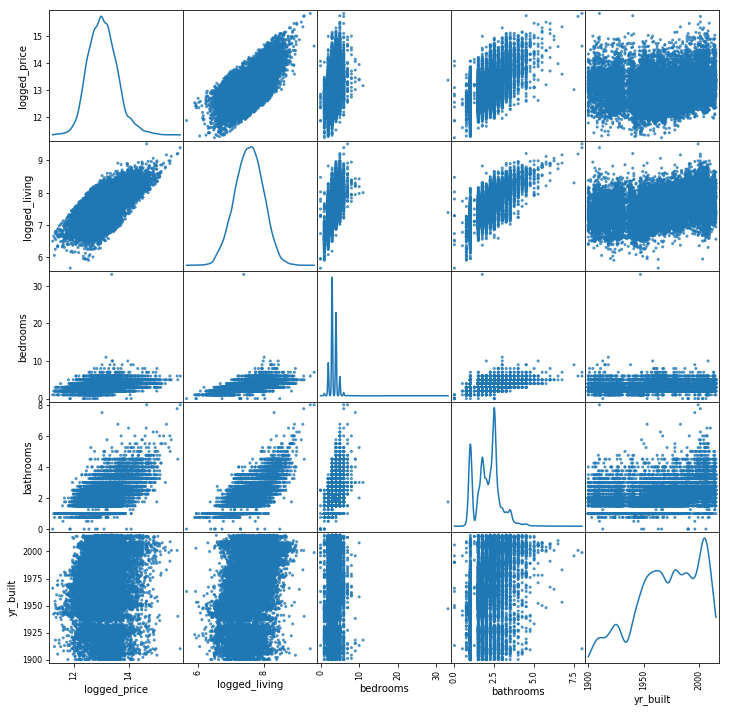

In [26]:
"""Descriptive Figures - 2: Scatter Matrix

Main variables + dependent variable

"""
smaller_frame=df[['logged_price', "logged_living", "bedrooms", 
           "bathrooms", "yr_built"]]
from pandas.plotting import scatter_matrix
axeslist=scatter_matrix(smaller_frame, alpha=0.8, figsize=(12, 12), diagonal="kde")
for ax in axeslist.flatten():
    ax.grid(False)

pylab.savefig('Scatter Matrix_main', dpi = 80, figsize = (20,6))
plt.show()    

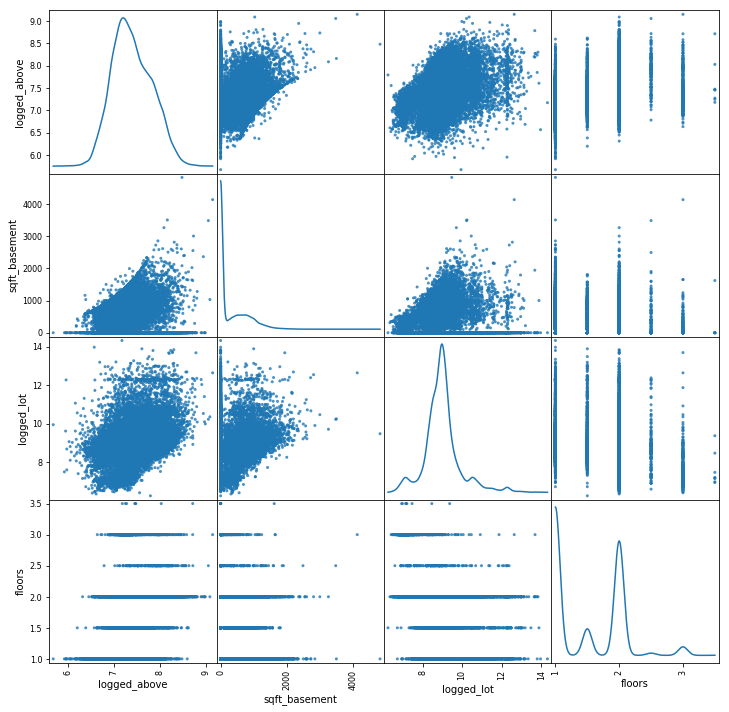

In [16]:
"""Descriptive Figures - 3: Scatter Matrix

"""
smaller_frame=df[["logged_above", "sqft_basement", "logged_lot", "floors"]]
from pandas.plotting import scatter_matrix
axeslist=scatter_matrix(smaller_frame, alpha=0.8, figsize=(12, 12), diagonal="kde")
for ax in axeslist.flatten():
    ax.grid(False)

pylab.savefig('Scatter Matrix_other', dpi = 80, figsize = (20,6))
plt.show()

In [ ]:
""" From above, I see I need to detect and remove outliers.  
However, given some of the variables are not likely to be normally distributed, 
that being said that the "outliers" could be just results from the non-normality.
Thus, I need a closer look into them to determine whether to remove the data point. 
"""

In [6]:
"""Outlier Detection - 1: Descriptive Stats

"""

df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,...,lat,long,yr,month,month_all,logged_price,logged_living,logged_lot,logged_above,Grade
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,1788.390691,...,47.560053,-122.213896,2014.322954,6.574423,6.449868,13.047817,7.550335,8.989956,7.394877,3.651275
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,828.090978,...,0.138564,0.140828,0.467616,3.115308,3.720034,0.526685,0.424807,0.902425,0.427631,1.057934
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,290.000000,...,47.155900,-122.519000,2014.000000,1.000000,1.000000,11.225243,5.669881,6.253829,5.669881,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,...,47.471000,-122.328000,2014.000000,4.000000,3.000000,12.682152,7.263330,8.525161,7.081709,3.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,1560.000000,...,47.571800,-122.230000,2014.000000,6.000000,6.000000,13.017003,7.554859,8.938269,7.352441,3.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,2210.000000,...,47.678000,-122.125000,2015.000000,9.000000,10.000000,13.377006,7.843849,9.276877,7.700748,4.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,...,47.777600,-121.315000,2015.000000,12.000000,13.000000,15.856731,9.513404,14.317109,9.149528,10.000000


In [ ]:
""" From above description: I want to take a closer look at the large numbers of bedrooms and large numbers of bathrooms.

"""

In [24]:
""" Outlier Detection - 2: Close-up

"""

print(df[df["bathrooms"]==8])
print()
print(df[df['bedrooms']>7])

            date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
7252  2014-10-13  7700000.0         6        8.0        12050     27600   
12777 2014-05-05  2280000.0         7        8.0        13540    307752   

       floors  waterfront  view  condition    ...          lat     long    yr  \
7252      2.5           0     3          4    ...      47.6298 -122.323  2014   
12777     3.0           0     4          3    ...      47.6675 -121.986  2014   

       month  logged_price  logged_living  logged_lot  logged_above  Grade  \
7252      10     15.856731       9.396820   10.225571      9.056023      7   
12777      5     14.639686       9.513404   12.637050      9.149528      7   

       month_all  
7252         6.0  
12777        1.0  

[2 rows x 23 columns]

            date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
1660  2014-12-04   490000.0         8       5.00         2800      2580   
4035  2014-10-07  2150000.0         8       6.00         4340   

In [ ]:
""" From above, I think the 8 bathrooms might be possible given both of the houses have more than 2 floors and nearly 8 bedrooms.
However, I decide to remove outliers from "bedrooms" since some of the data does not make sense.
Despite the obvious error of 33 bedrooms, it is less likely that one has 11 bedrooms with only 3 bathrooms in a 2-floor house.  

"""

In [6]:
"""Outliers detection - 3: Function 

Median absolute deviation (MAD)
Noted that this requires normality, since otherwise the appearances of "outliers" might only from the non-normality of the data.

Normally distributed variables: logged_price, logged_living, logged_lot, logged_above, bedrooms
"""

# Step 2: Median absolute deviation (MAD) to detect outliers and then give these outliers a closer look.


# Define a function for the detection:
def outliers_mad(ys):
    threshold = 3.5

    median_y = np.median(np.array(ys))
    MAD_y = np.median(np.abs(np.array(ys - median_y)))
    df['MAD'] = 0.6745 * (ys - median_y) / MAD_y 
    print(df.columns)
    

# Call the function:
#outliers_mad(df["logged_lot"])
outliers_mad(df["bedrooms"])

def Nan(df):
    if df['MAD'] > 3.5:
        return None
    else:
        return df['MAD']

# create sex_new 
df['MAD_Drop']=df.apply(Nan,axis=1)
print(df['MAD_Drop'].isnull().any())
#df['MAD_Drop'].head(12)
df.dropna(subset = ['MAD_Drop'], inplace = True)
print(df.shape)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long',
       'yr', 'month_all', 'Grade', 'logged_price', 'logged_living',
       'logged_lot', 'logged_above', 'MAD'],
      dtype='object')
True
(21602, 21)


In [5]:
"""Descriptive Figure - 4: Location

"""

df.describe()"""Heat map: to show where are the house info located.

"""
# Step 1: zoom in on the map to concentrate at the mean latitude and mean longitude. 
house_map = folium.Map(location = [df['lat'].mean(), df['long'].mean()], zoom_start=9)

# Step 2: iterate through the rows to add lat and long to the map.
HeatMap([[row["lat"], row["long"]] for name, row in df.iterrows()]).add_to(house_map)


# Save in results folder.
house_map.save(os.path.join('results', 'house_map.html'))

# Show the heatmap: need to be after the save.
house_map

In [11]:
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

dark2_cmap = brewer2mpl.get_map('Dark2', 'Qualitative', 7)
dark2_colors = dark2_cmap.mpl_colors

def scatter_by(df, scatterx, scattery, by=None, figure=None, axes=None, colorscale=dark2_cmap, labeler={}, mfunc=None, setupfunc=None, mms=8):
    cs=copy.deepcopy(colorscale.mpl_colors)
    if not figure:
        figure=plt.figure(figsize=(8,8))
    if not axes:
        axes=figure.gca()
    x=df[scatterx]
    y=df[scattery]
    if not by:
        col=random.choice(cs)
        axes.scatter(x, y, cmap=colorscale, c=col)
        if setupfunc:
            axeslist=setupfunc(axes, figure)
        else:
            axeslist=[axes]
        if mfunc:
            mfunc(axeslist,x,y,color=col, mms=mms)
    else:
        cs=list(np.linspace(0,1,len(df.groupby(by))))
        xlimsd={}
        ylimsd={}
        xs={}
        ys={}
        cold={}
        for k,g in df.groupby(by):
            col=cs.pop()
            x=g[scatterx]
            y=g[scattery]
            xs[k]=x
            ys[k]=y
            c=colorscale.mpl_colormap(col)
            cold[k]=c
            axes.scatter(x, y, c=c, label=labeler.get(k,k), s=40, alpha=0.2);
            xlimsd[k]=axes.get_xlim()
            ylimsd[k]=axes.get_ylim()
        xlims=[min([xlimsd[k][0] for k in xlimsd.keys()]), max([xlimsd[k][1] for k in xlimsd.keys()])]
        ylims=[min([ylimsd[k][0] for k in ylimsd.keys()]), max([ylimsd[k][1] for k in ylimsd.keys()])]
        axes.set_xlim(xlims)
        axes.set_ylim(ylims)
        if setupfunc:
            axeslist=setupfunc(axes, figure)
        else:
            axeslist=[axes]
        if mfunc:
            for k in xs.keys():
                mfunc(axeslist,xs[k],ys[k],color=cold[k], mms=mms);
    axes.set_xlabel(scatterx);
    axes.set_ylabel(scattery);
    
    return axes

def make_rug(axeslist, x, y, color='b', mms=8):
    axes=axeslist[0]
    zerosx1=np.zeros(len(x))
    zerosx2=np.zeros(len(x))
    xlims=axes.get_xlim()
    ylims=axes.get_ylim()
    zerosx1.fill(ylims[1])
    zerosx2.fill(xlims[1])
    axes.plot(x, zerosx1, marker='|', color=color, ms=mms)
    axes.plot(zerosx2, y, marker='_', color=color, ms=mms)
    axes.set_xlim(xlims)
    axes.set_ylim(ylims)
    return axes

F


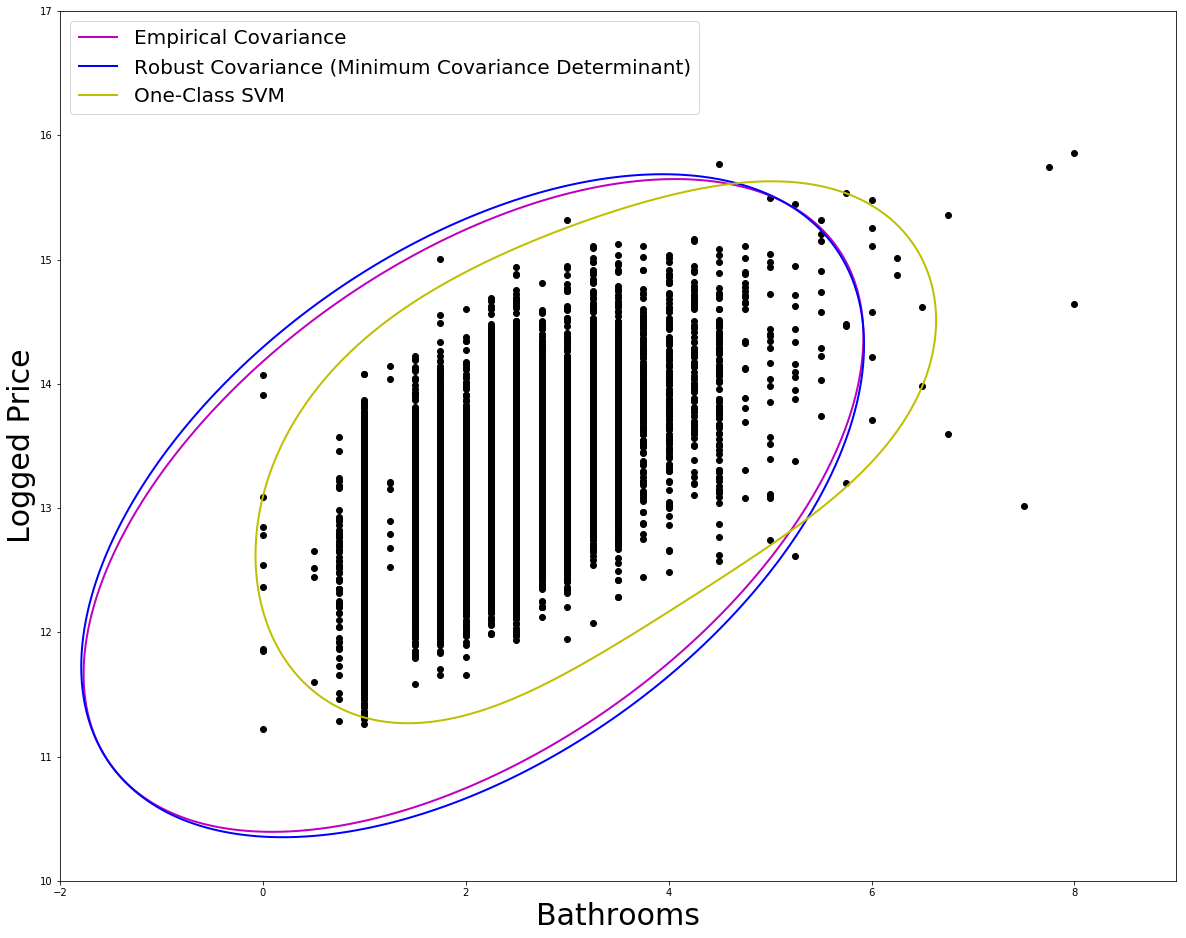

In [35]:

# Get data
X = df.as_matrix(columns = ['bathrooms', 'logged_price'])
#X1 = [df["logged_living"], df["logged_price"]]

# Define "classifiers" to be used
classifiers = {"Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.001),
               "Robust Covariance (Minimum Covariance Determinant)":
               EllipticEnvelope(contamination = 0.001),
               "One-Class SVM": OneClassSVM(nu=0.001, gamma=0.05)}

colors = ['m', 'b', 'y']
legend1 = {}


# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(-2, 9, 300), np.linspace(10, 17, 300))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(20, 16))
    clf.fit(X)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])

print("F")

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(20, 16)) 
#plt.title("Outlier Detection", fontsize = 25)
plt.scatter(X[:, 0], X[:, 1], color='black')
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=20))

plt.xlabel("Bathrooms", fontsize = 30)
plt.ylabel("Logged Price", fontsize = 30)

#pylab.save("Outlier Detection MCD")
pylab.savefig("Outlier Detection Bathrooms_Emporocal, Roubst, OCSVM")
plt.show()

F


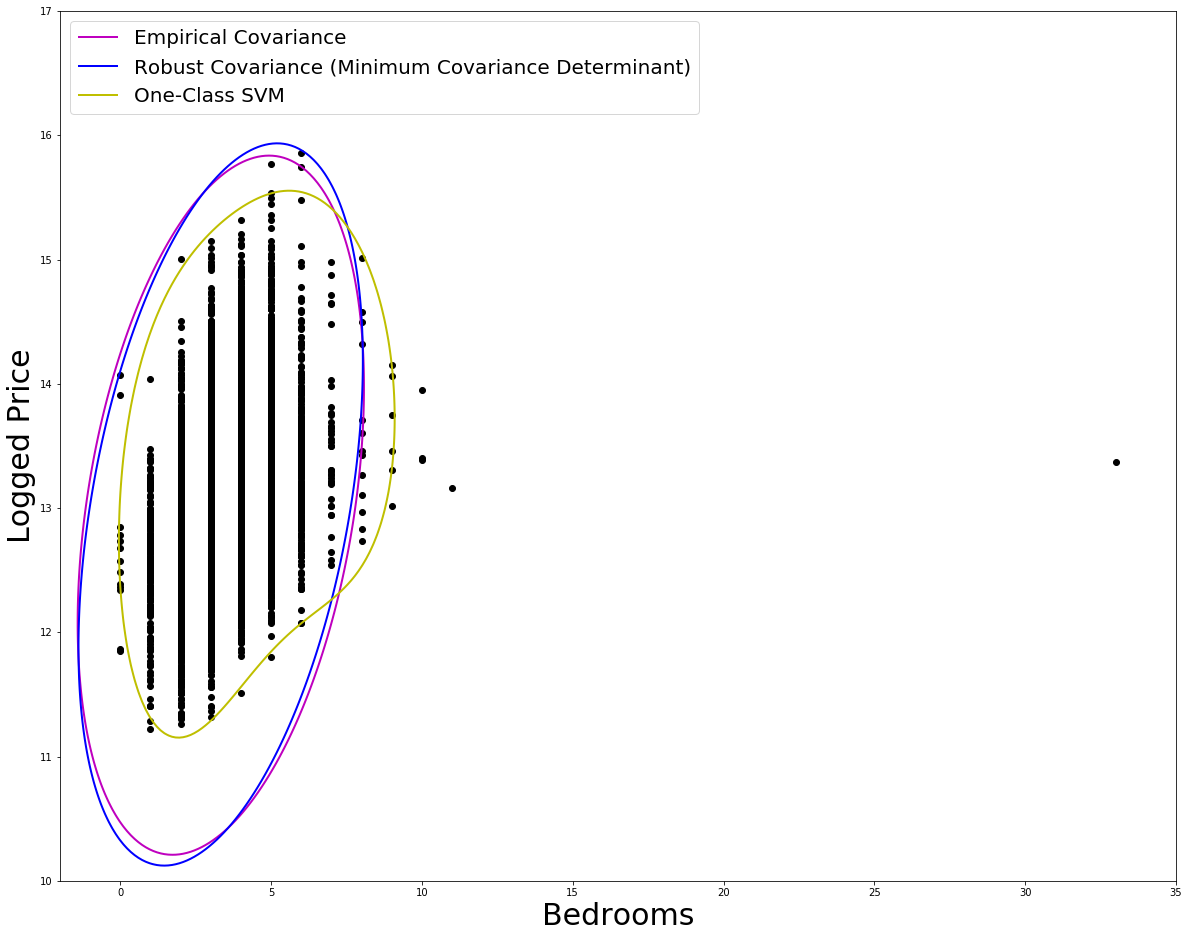

In [36]:

# Get data
X = df.as_matrix(columns = ['bedrooms', 'logged_price'])
#X1 = [df["logged_living"], df["logged_price"]]

# Define "classifiers" to be used
classifiers = {"Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.001),
               "Robust Covariance (Minimum Covariance Determinant)":
               EllipticEnvelope(contamination = 0.001),
               "One-Class SVM": OneClassSVM(nu=0.001, gamma=0.05)}

colors = ['m', 'b', 'y']
legend1 = {}


# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(-2, 35, 300), np.linspace(10, 17, 300))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(20, 16))
    clf.fit(X)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])

print("F")

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(20, 16)) 
#plt.title("Outlier Detection", fontsize = 25)
plt.scatter(X[:, 0], X[:, 1], color='black')
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=20))

plt.xlabel("Bedrooms", fontsize = 30)
plt.ylabel("Logged Price", fontsize = 30)

#pylab.save("Outlier Detection MCD")
pylab.savefig("Outlier Detection Bedrooms_Emporocal, Roubst, OCSVM")
plt.show()

In [9]:
"""Plot the svr over each explanatory variable: 

When calling this function, you need to call plt.show(), and set the xlab etc.

"""

def plot_regression(X, y, y_pred):
    lw = 2
    plt.scatter(X, y, color='darkorange', label='data')
    plt.scatter(X, y_pred, color='navy', lw=lw, label='RBF model')
    plt.legend()


In [13]:
"""Function: 

Test the best-fitted "training Vs testing" ratio AND best kernel model.

"""

def model_selection(lst):
    # Set ratio:
    ratios = [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8] 
    test_sizes = []

    # Set X and Y
    X = df.as_matrix(columns=lst)
    y = np.array(df["logged_price"])
    
    # Set Kernel:
    kernel = ["rbf", "linear"]
    #, "linear"
    for size in ratios:
        test_size = 1/size
        test_sizes.append(test_size)
    
    for test_size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
        for k in kernel:
            svr = SVR(kernel = k) 
            svr_fit = svr.fit(X_train, y_train) 
            svr_pred = svr.predict(X_train)
            svr_pred_test = svr.predict(X_test) #Here we are simply predicting on our input to visualize the results
            rmse = metrics.mean_squared_error(y_test, svr_pred_test) #mean-squared-error: (sum((Y_actual-Y_predicted)^2)^0.5
            print("Kernel - {}".format(k))
            print("Test data ratio: {} out of 1.".format(np.round(test_size, 2)))
            print("RMSE - {}".format(rmse))
            r2 = metrics.r2_score(y_test, svr_pred_test)
            print("R2 - {}".format(r2))
            print()


In [14]:
"""Function: 

Randomly choose a random number of variables from lst_other, 
and append the variables to the lst_main to make the final list for independent variable. 

"""
# Create a list of independent variables:
lst_main = ["logged_living", "bedrooms", 
           "bathrooms", "yr_built", "month_all"]
lst_other = ["logged_above", "sqft_basement", "logged_lot", "floors", "Grade"]

# Create random selected variables lists of a given size:
def models(size):
    lst_select = list(itertools.combinations(lst_other,size))
    print(lst_select)
    print()
    print("Model Selected:")
    print()

    lst_models = []
    for ele in lst_select:
        lst_main = ["logged_living", "bedrooms", 
           "bathrooms", "yr_built", "month_all"]
        lst_main.extend(ele)
        lst_models.append(lst_main)
        print(lst_main)

    print()
    return lst_models


In [6]:
""" Model Selectcion Core function: 

Define the number of other variables, and together with the main variables, run the svr.


"""
size = 1

for lst in models(size):
    print(lst)
    model_selection(lst)

[('logged_above',), ('sqft_basement',), ('logged_lot',), ('floors',)]

Model Selected:

['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'Grade', 'logged_above']
['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'Grade', 'sqft_basement']
['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'Grade', 'logged_lot']
['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'Grade', 'floors']

['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'Grade', 'logged_above']
Kernel - rbf
Test data ratio: 0.33 out of 1.
RMSE - 0.1357722227240785
R2 - 0.5117334174317276

Kernel - rbf
Test data ratio: 0.29 out of 1.
RMSE - 0.1338030746080425
R2 - 0.5257626385105367

Kernel - rbf
Test data ratio: 0.25 out of 1.
RMSE - 0.1330225860880214
R2 - 0.5312891653394979

Kernel - rbf
Test data ratio: 0.22 out of 1.
RMSE - 0.13209555318454777
R2 - 0.5361191002383702

Kernel - rbf
Test data ratio: 0.2 out of 1.
RMSE - 0.131742480790425

In [38]:
""" Selected Model: With Outliers

"""

lst_1 = ['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'logged_above', 'logged_lot', 'floors']
model_selection(lst_1)

Kernel - rbf
Test data ratio: 0.12 out of 1.
RMSE - 0.12051479785180606
R2 - 0.5700773287125193



In [17]:
""" Selected Model: Without Outliers

"""

lst = ['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'logged_above', 'logged_lot', 'floors']
X = df.as_matrix(columns=lst)
y = np.array(df["logged_price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=20)

svr = SVR(kernel = "rbf") 
svr_fit = svr.fit(X_train, y_train) 
svr_pred = svr.predict(X_train)
svr_pred_test = svr.predict(X_test) 
rmse = metrics.mean_squared_error(y_test, svr_pred_test)

print("RMSE - {}".format(rmse))
r2 = metrics.r2_score(y_test, svr_pred_test)
print("R2 - {}".format(r2))
print()

RMSE - 0.1268103744490221
R2 - 0.5500961881504325



In [18]:
""" Parameter Tuning: to perfect the svr model

"""

from sklearn import svm
from sklearn.model_selection import GridSearchCV

lst = ['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'logged_above', 'logged_lot', 'floors']
X = df.as_matrix(columns=lst)
y = np.array(df["logged_price"])

parameters = {'kernel':['rbf'], 'C':[1, 10], 'gamma': [0.14, 0.1]}
svr = SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X, y)
print(clf.best_score_)
print(clf.get_params)
print(clf.best_estimator_)

0.532881595757
<bound method BaseEstimator.get_params of GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.14, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)>
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [8]:
""" Model Chosen: 

"""

lst = ['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'logged_above', 'logged_lot', 'floors']
X = df.as_matrix(columns=lst)
y = np.array(df["logged_price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=20)

svr = SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
          kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
svr_fit = svr.fit(X_train, y_train) 
svr_pred = svr.predict(X_train)
svr_pred_test = svr.predict(X_test) 
rmse = metrics.mean_squared_error(y_test, svr_pred_test)

print("RMSE - {}".format(rmse))
r2 = metrics.r2_score(y_test, svr_pred_test)
print("R2 - {}".format(r2))
print()

plot_regression(X_train[:,0], y_train, svr_pred)
plt.xlabel('logged_living', fontsize = 15)
plt.ylabel('logged price', fontsize = 15)
plt.title('Logged price Vs logged_living', fontsize = 18)

pylab.savefig("SVR logged price vs logged living")
plt.show()


RMSE - 0.12447184234526214
R2 - 0.5583929423567466



NameError: name 'plot_regression' is not defined

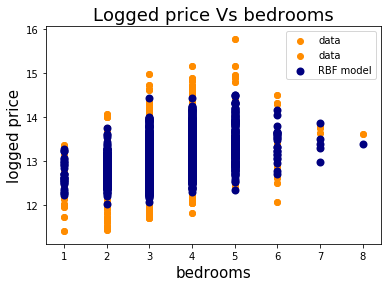

In [12]:
""" 

"""

plot_regression(X_test[:,1], y_test, svr_pred_test)
plt.xlabel('bedrooms', fontsize = 15)
plt.ylabel('logged price', fontsize = 15)
plt.title('Logged price Vs bedrooms', fontsize = 18)

pylab.savefig("logged price vs bedrooms")
plt.show()
    

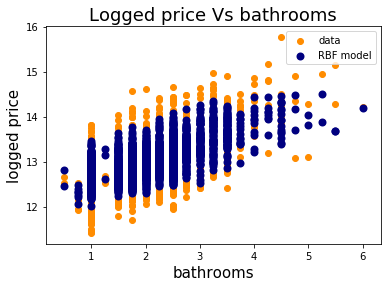

In [13]:
plot_regression(X_test[:,2], y_test, svr_pred_test)
plt.xlabel('bathrooms', fontsize = 15)
plt.ylabel('logged price', fontsize = 15)
plt.title('Logged price Vs bathrooms', fontsize = 18)

pylab.savefig("logged price vs bathrooms")
plt.show()

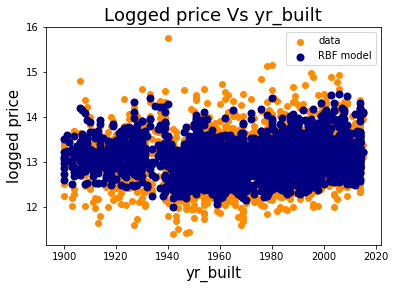

In [14]:
plot_regression(X_test[:,3], y_test, svr_pred_test)
plt.xlabel('yr_built', fontsize = 15)
plt.ylabel('logged price', fontsize = 15)
plt.title('Logged price Vs yr_built', fontsize = 18)

pylab.savefig("logged price vs yr_built")
plt.show()

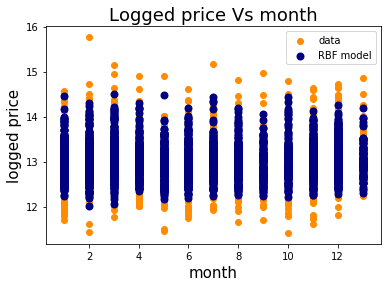

In [15]:
plot_regression(X_test[:,4], y_test, svr_pred_test)
plt.xlabel('month', fontsize = 15)
plt.ylabel('logged price', fontsize = 15)
plt.title('Logged price Vs month', fontsize = 18)

pylab.savefig("logged price vs month")
plt.show()

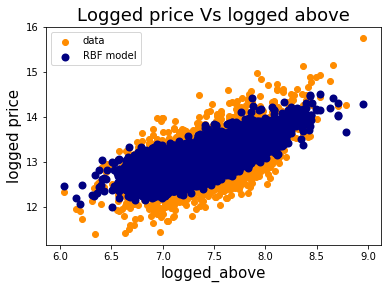

In [16]:
plot_regression(X_test[:,5], y_test, svr_pred_test)
plt.xlabel('logged_above', fontsize = 15)
plt.ylabel('logged price', fontsize = 15)
plt.title('Logged price Vs logged above', fontsize = 18)

pylab.savefig("logged price vs logged above")
plt.show()

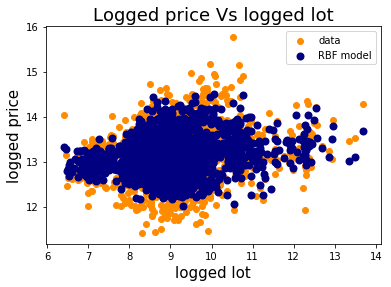

In [17]:
plot_regression(X_test[:,6], y_test, svr_pred_test)
plt.xlabel('logged lot', fontsize = 15)
plt.ylabel('logged price', fontsize = 15)
plt.title('Logged price Vs logged lot', fontsize = 18)

pylab.savefig("logged price vs logged lot")
plt.show()

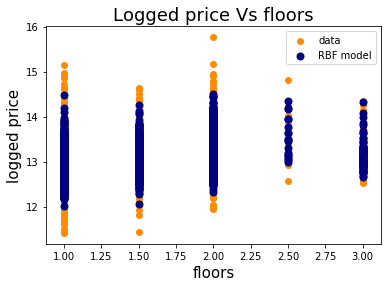

In [18]:
plot_regression(X_test[:,7], y_test, svr_pred_test)
plt.xlabel('floors', fontsize = 15)
plt.ylabel('logged price', fontsize = 15)
plt.title('Logged price Vs floors', fontsize = 18)

pylab.savefig("logged price vs floors")
plt.show()

In [10]:
"""
lst = ['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'logged_above', 'logged_lot', 'floors']
"""

from tkinter import *
import tkinter.messagebox as ms

def predict():
    lst = np.array([float(entry1.get()), float(entry2.get()), float(entry3.get()), float(entry4.get()), 
                    float(entry5.get()), float(entry6.get()), float(entry7.get()), float(entry8.get())]).reshape(1, -1)
    logged_price = svr.predict(lst)
    print("Predicted Price: \n{}".format(np.round(logged_price, decimals=4)))
    price = np.e**logged_price
    ms.showinfo("Prediction Window","Predicted Price: \n$ {}".format(np.round(price, decimals=2)))
    
root = Tk()

l1 = Label(root, text="Logged Living", fg = "red")
entry1 = Entry(root)
l2 = Label(root, text="Bedrooms", fg = "blue")
entry2 = Entry(root)
l3 = Label(root, text="Bathrooms", fg = "purple")
entry3 = Entry(root)
l4 = Label(root, text="Year built", fg = "green")
entry4 = Entry(root)
l5 = Label(root, text="month", fg = "salmon")
entry5 = Entry(root)
l6 = Label(root, text="Logged above", fg = "black")
entry6 = Entry(root)
l7 = Label(root, text="Logged Lot", fg = "gray")
entry7 = Entry(root)
l8 = Label(root, text="Floors", fg = "orange")
entry8 = Entry(root)


l1.grid(row = 0, sticky = E)
l2.grid(row = 1, sticky = E)
l3.grid(row = 2, sticky = E)
l4.grid(row = 3, sticky = E)
l5.grid(row = 4, sticky = E)
l6.grid(row = 5, sticky = E)
l7.grid(row = 6, sticky = E)
l8.grid(row = 7, sticky = E)

entry1.grid(row = 0, column = 1)
entry2.grid(row = 1, column = 1)
entry3.grid(row = 2, column = 1)
entry4.grid(row = 3, column = 1)
entry5.grid(row = 4, column = 1)
entry6.grid(row = 5, column = 1)
entry7.grid(row = 6, column = 1)
entry8.grid(row = 7, column = 1)

c = Checkbutton(root, text = "I swear these are resonable")
c.grid(columnspan = 2)

button = Button(root, text = "Predict", command = predict)
button.grid(columnspan = 2)

root.mainloop()

Predicted Price: 
[ 13.2689]
